In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from nltk.corpus import stopwords
import re
import math
import nltk
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('wordnet')
!export OBJC_DISABLE_INITIALIZE_FORK_SAFETY=YES

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/siddheshpisal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
def clean_text(c):
    c = F.lower(c)
    c = F.regexp_replace(c, "^rt ", "")
    c = F.regexp_replace(c, "(https?\://)\S+", "")
    c = F.regexp_replace(c, "[^a-zA-Z0-9\\s]", "")
    #c = split(c, "\\s+") tokenization...
    return c

stop_words = set(stopwords.words('english')) 

def one_grams(s):
    return s.split(" ")



In [5]:
# Read the files
posTXT = spark.read.option("header", "true").option("inferSchema", "true").csv("True.csv")
negTXT = spark.read.option("header", "true").option("inferSchema", "true").csv("Fake.csv")

In [6]:
# Some elements in text column are empty, so we will drop them
# Clean the text using above utility function

posTXT = posTXT.dropna().withColumn("text", clean_text(F.col("text")))
negTXT = negTXT.dropna().withColumn("text", clean_text(F.col("text")))

In [15]:
# Convert the text to RDD
pos_text = posTXT.select("text").rdd.map(lambda x: x.text)
neg_text = negTXT.select("text").rdd.map(lambda x: x.text)

In [16]:
# Split the lines into words to calculate term frequency and inverse data frequency
posTerms = pos_text.map(lambda line: one_grams(line))
negTerms = neg_text.map(lambda line: one_grams(line))
terms = posTerms + negTerms

In [17]:
terms = terms.map(lambda x: list(set(x).difference(stop_words)))


In [ ]:
"""
Uncomment the following if you want to lemmatize the terms
"""
# def lemmatization(x):
#     lemmatizer = WordNetLemmatizer()
#     finalLem = [lemmatizer.lemmatize(s) for s in x]
#     return finalLem

# terms = terms.map(lemmatization)


### Q2: TF-IDF 

In [18]:

def tf(terms):
    word_count = terms.flatMap(list).map(lambda word: (word, 1)).reduceByKey(lambda x, y: x + y)
    return word_count 


def idf(terms):
    word_count = terms.flatMap(lambda x: list(set(x))).map(lambda word: (word, 1)).reduceByKey(lambda x, y: x + y)
    return word_count 


def tfidf(terms): 
    dCount = terms.count()
    tfreq = tf(terms)
    dfreq = idf(terms)
    return tfreq.join(dfreq).map(lambda p :(p[0], p[1][0] * math.log(dCount/p[1][1]))).sortBy( lambda p : - p[1])


### Q3: Main findings of running TF-IDF on the text 

The text mentions President Donald Trump and the USA presidential elections. It also mentions of Hillary and Bill Clinton. 



In [19]:

topTerms = list(map(lambda p:p[0], tfidf(terms).collect()[:150]))
print(topTerms)


['new', 'told', 'donald', 'also', 'people', 'could', 'one', 'last', 'state', 'states', 'like', 'time', 'two', 'house', 'government', 'trump', 'first', 'reuters', 'united', 'washington', 'us', 'even', 'republican', 'news', 'would', 'president', 'made', 'many', 'years', 'country', 'year', 'since', 'white', 'make', 'say', 'former', 'get', 'campaign', 'via', 'election', 'back', 'national', 'including', 'may', 'week', 'obama', 'going', 'political', 'take', 'way', 'presidential', 'called', 'image', 'saying', 'according', 'american', 'support', 'well', 'party', 'know', 'think', 'security', 'statement', 'right', 'office', 'part', 'democratic', 'media', 'another', 'much', 'law', 'still', 'want', 'public', 'see', 'america', 'tuesday', 'hillary', 'group', 'wednesday', 'administration', 'world', 'day', 'go', 'clinton', 'officials', 'says', 'asked', 'thursday', 'work', 'friday', 'next', 'monday', 'foreign', 'around', 'republicans', 'help', 'need', 'whether', 'took', 'three', 'federal', 'vote', 'com

### Q4: Word cloud of some top terms

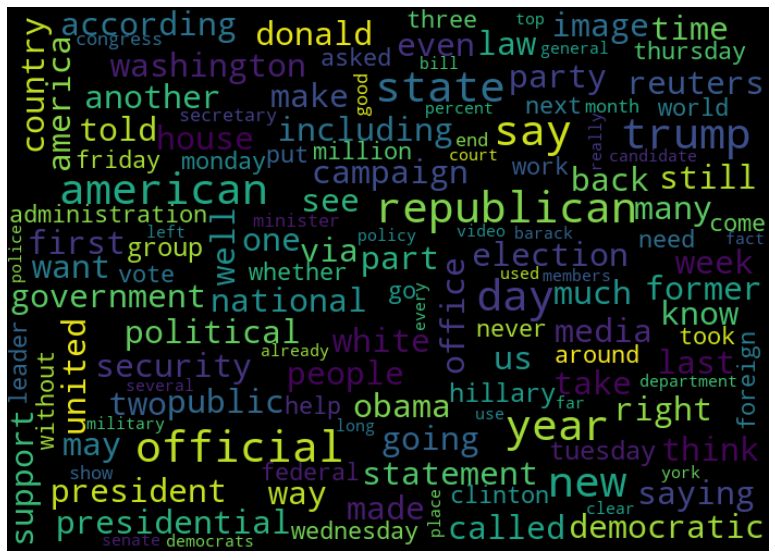

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Generate a word cloud image
wordcloud = WordCloud().generate(" ".join(topTerms))

# lower max_font_size
wordcloud = WordCloud(max_font_size=40, width=700, height=500).generate(" ".join(topTerms))
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Q5: Use-case

A social network is interested in producing an engine for filtering fake news. For this purpose they want to run your algorithm on every post that is published. The goal is to verify the correctness of the news in the post as quickly as possible and publish it if it is correct and archived otherwise. Describe the technological difficulties of this type of system, especially regarding the storage of unstructured data and real-time information processing.